In [ ]:
!pip install mdptoolbox-hiive
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

In [ ]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    
#plot_lake(env, policy)

In [ ]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done,_, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail


In [ ]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy 

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


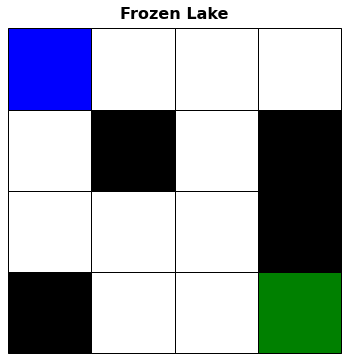

In [ ]:
# Setup 4x4
env = gym.make('FrozenLake-v1').unwrapped

env.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env)

In [ ]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            policy = policy.reshape(4,4)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            if showResults:
                title = 'FrozenLake_VI_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_e' + str(e)
                plot_lake(env, policy, title)
            
            testNum = testNum + 1
                
    endTime = time.time() - t0
    print("Time taken: %.2f" %endTime)
    
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-05,	0.00,	4,	0.345235
0.10,	1E-10,	0.00,	9,	0.345239
0.10,	1E-15,	0.00,	14,	0.345239
0.10,	1E-20,	0.00,	19,	0.345239
0.30,	1E-05,	0.00,	8,	0.375101
0.30,	1E-10,	0.00,	17,	0.375103
0.30,	1E-15,	0.00,	26,	0.375103
0.30,	1E-20,	0.00,	36,	0.375103
0.60,	1E-05,	0.00,	17,	0.447647
0.60,	1E-10,	0.00,	37,	0.447649
0.60,	1E-15,	0.00,	58,	0.447649
0.60,	1E-20,	0.00,	73,	0.447649
0.90,	1E-05,	0.00,	77,	0.639019
0.90,	1E-10,	0.01,	162,	0.639020
0.90,	1E-15,	0.01,	246,	0.639020
0.90,	1E-20,	0.02,	270,	0.639020
Time taken: 0.13
Best Result:
	Success = 80.10
	Gamma = 0.90
	Epsilon= 1E-15


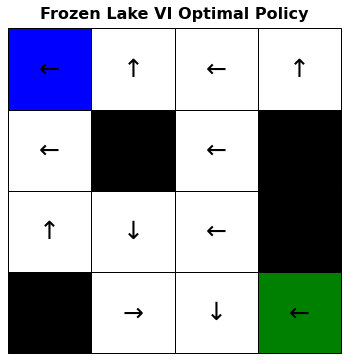

In [ ]:
gammas   = [0.1, 0.3, 0.6, 0.9]
epsilons = [1e-5, 1e-10, 1e-15, 1e-20]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward']
df = vi_data[interest]
df.to_csv('VI_convergence.csv')

#vi_data.head()
# Plot most successful gamma and epsilon

# find the score with the highest success percentage and get its policy
bestRun = vi_data['success_pct'].argmax()
best_policy = vi_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake VI Optimal Policy'
plot_lake(env, best_policy, title)

# write all results to csv file
csvFile = 'VI_results.csv'
vi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f\n\tEpsilon= %.E' % (vi_data['success_pct'].max(), vi_data['gamma'][bestRun], vi_data['epsilon'][bestRun]))


Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.90,	1E-20,	0.05,	270,	0.639020
0.90,	1E-19,	0.06,	270,	0.639020
0.90,	1E-18,	0.03,	270,	0.639020
0.90,	1E-17,	0.03,	270,	0.639020
0.90,	1E-16,	0.03,	267,	0.639020
0.90,	1E-15,	0.04,	246,	0.639020
0.90,	1E-14,	0.04,	229,	0.639020
0.90,	1E-13,	0.03,	212,	0.639020
0.90,	1E-12,	0.02,	195,	0.639020
0.90,	1E-11,	0.02,	179,	0.639020
0.90,	1E-10,	0.02,	162,	0.639020
0.90,	1E-09,	0.03,	145,	0.639020
0.90,	1E-08,	0.01,	128,	0.639020
0.90,	1E-07,	0.01,	111,	0.639020
0.90,	1E-06,	0.01,	94,	0.639020
0.90,	1E-05,	0.01,	77,	0.639019
Time taken: 0.79


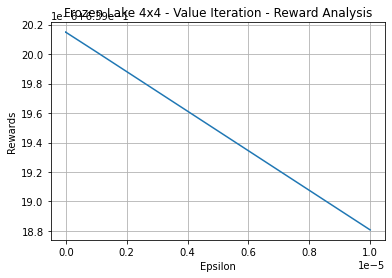

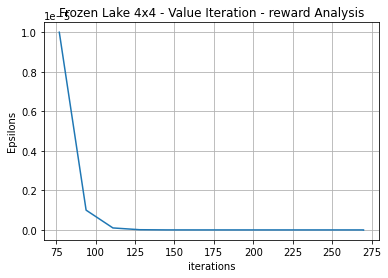

In [ ]:
option='4x4'
gammas   = [0.9]
epsilons = [1e-20, 1e-19, 1e-18, 1e-17, 1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8,1e-7,1e-6,1e-5]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'success_pct']
df = vi_data[interest]
iterations = df['iterations']
reward = df['reward']

plt.plot(epsilons,reward)
plt.xlabel('Epsilon')
plt.ylabel('Rewards')
plt.title('Frozen Lake ' + option + ' - Value Iteration - Reward Analysis')
plt.grid(True)
plt.show()

plt.plot(iterations, epsilons)
plt.xlabel('iterations')
plt.ylabel('Epsilons')
plt.title('Frozen Lake ' + option + ' - Value Iteration - reward Analysis')
plt.grid(True)
plt.show()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-20,	0.00,	19,	0.345239
0.20,	1E-20,	0.00,	27,	0.358992
0.30,	1E-20,	0.00,	36,	0.375103
0.40,	1E-20,	0.00,	46,	0.394332
0.50,	1E-20,	0.01,	58,	0.417861
0.60,	1E-20,	0.01,	73,	0.447649
0.70,	1E-20,	0.01,	99,	0.487267
0.80,	1E-20,	0.01,	140,	0.544196
0.90,	1E-20,	0.03,	270,	0.639020
0.99,	1E-20,	0.11,	987,	0.862837
1.00,	1E-20,	0.14,	1325,	0.931179
Time taken: 0.39


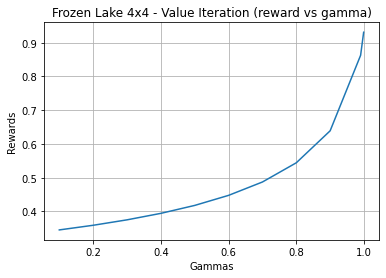

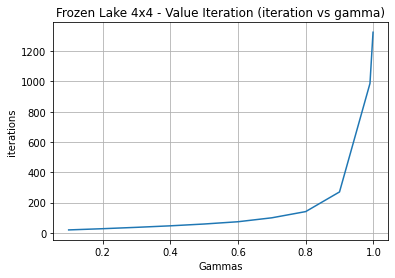

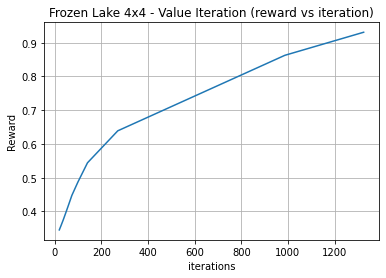

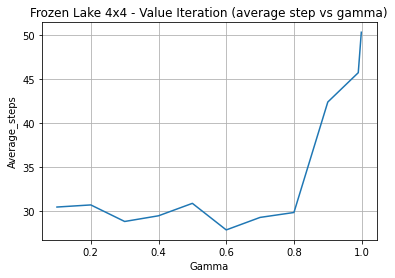

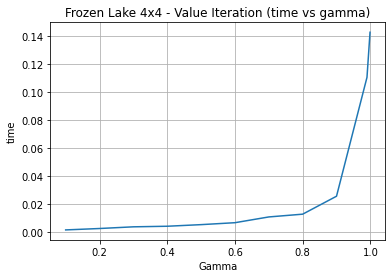

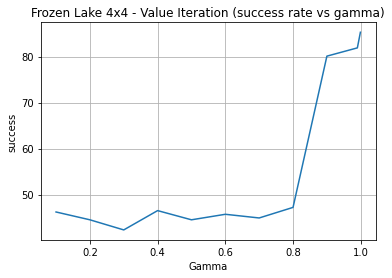

In [ ]:
option='4x4'
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
epsilons = [1e-20]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'success_pct']
df = vi_data[interest]
iterations = df['iterations']
reward = df['reward']
time = df['time']
steps = df['average_steps']
success = df['success_pct']

plt.plot(gammas,reward)
plt.xlabel('Gammas')
plt.ylabel('Rewards')
plt.title('Frozen Lake ' + option + ' - Value Iteration (reward vs gamma)')
plt.grid(True)
plt.show()


plt.plot(gammas, iterations)
plt.xlabel('Gammas')
plt.ylabel('iterations')
plt.title('Frozen Lake ' + option + ' - Value Iteration (iteration vs gamma)')
plt.grid(True)
plt.show()


plt.plot(iterations,reward)
plt.xlabel('iterations')
plt.ylabel('Reward')
plt.title('Frozen Lake ' + option + ' - Value Iteration (reward vs iteration)')
plt.grid(True)
plt.show()

plt.plot(gammas,steps)
plt.xlabel('Gamma')
plt.ylabel('Average_steps')
plt.title('Frozen Lake ' + option + ' - Value Iteration (average step vs gamma)')
plt.grid(True)
plt.show()

plt.plot(gammas,time)
plt.xlabel('Gamma')
plt.ylabel('time')
plt.title('Frozen Lake ' + option + ' - Value Iteration (time vs gamma)')
plt.grid(True)
plt.show()

plt.plot(gammas,success)
plt.xlabel('Gamma')
plt.ylabel('success')
plt.title('Frozen Lake ' + option + ' - Value Iteration (success rate vs gamma)')
plt.grid(True)
plt.show()

In [ ]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    import time
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        policy = np.array(test.policy)
        policy = policy.reshape(4,4)
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        if showResults:
            title = 'frozenlake_pi_' + str(rows) + 'x' + str(cols) + '_g' + str(g)
            plot_lake(env, policy, title)
        
        testnum = testnum + 1
            
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # see differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [ ]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pi_data  = policyIteration(T, R, gammas, showResults=False)

interest = ['gamma', 'time', 'iterations', 'reward']
df = pi_data[interest]
df.to_csv('PI_convergence.csv')

#pi_data.head()

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.01,	4,	0.345239
0.20,	0.00,	4,	0.358992
0.30,	0.00,	4,	0.375103
0.40,	0.00,	4,	0.394332
0.50,	0.00,	4,	0.417861
0.60,	0.00,	4,	0.447649
0.70,	0.00,	4,	0.487267
0.80,	0.00,	5,	0.544196
0.90,	0.00,	6,	0.639020
Time taken: 0.05


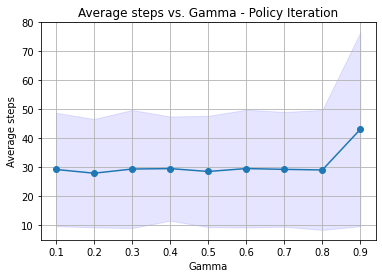

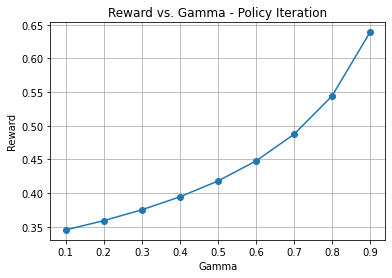

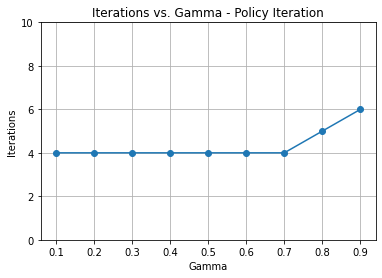

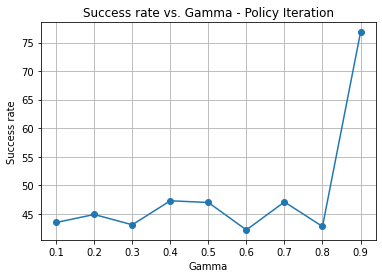

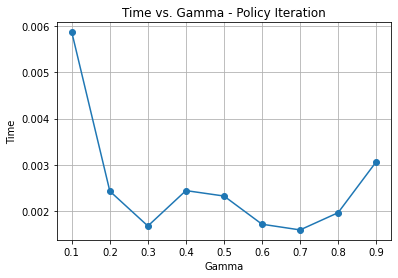

In [ ]:
# Compare number of iterations with lowest epsilon

# average steps vs gamma 
x = gammas
y = pi_data['average_steps']
sigma = pi_data['steps_stddev']

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')
plt.fill_between(x, y-sigma, y+sigma, color='b', alpha=0.1)

plt.title('Average steps vs. Gamma - Policy Iteration')
plt.xlabel('Gamma')
plt.ylabel('Average steps')
plt.grid(True)

# reward vs gamma
interest = ['gamma', 'time', 'iterations', 'reward']
df = pi_data[interest]
iterations = df["iterations"]
reward = df["reward"]

fig = plt.figure(figsize=(6,4))
plt.plot(x, reward, 'o-')

plt.title('Reward vs. Gamma - Policy Iteration')
plt.xlabel('Gamma')
plt.ylabel('Reward')
plt.grid(True)

# iteration vs gamma
fig = plt.figure(figsize=(6,4))
plt.plot(x, iterations, 'o-')

plt.title('Iterations vs. Gamma - Policy Iteration')
plt.xlabel('Gamma')
plt.ylabel('Iterations')
plt.grid(True)
plt.ylim([0, 10])

# success rate vs gamma
x = pi_data['gamma']
y = pi_data['success_pct']
fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')

plt.title('Success rate vs. Gamma - Policy Iteration')
plt.xlabel('Gamma')
plt.ylabel('Success rate')
plt.grid(True)

# time vs gamma
x = pi_data['gamma']
y = pi_data['time']
fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')

plt.title('Time vs. Gamma - Policy Iteration')
plt.xlabel('Gamma')
plt.ylabel('Time')
plt.grid(True)


Best Result:
	Success = 78.10
	Gamma = 0.90


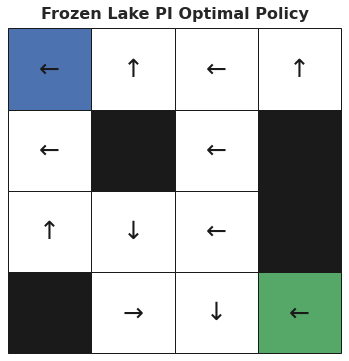

In [ ]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = pi_data['success_pct'].argmax()

best_policy = pi_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake PI Optimal Policy'
plot_lake(env, best_policy, title)

# write all results to csv file
csvFile = 'PI_results.csv'
pi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f' % (pi_data['success_pct'].max(), pi_data['gamma'][bestRun]))

In [ ]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        policy = np.array(test.policy)
                        policy = policy.reshape(4,4)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            title = 'FrozenLake_QL_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_a' + str(a) + '_adecay' + str(a_decay) + '_edecay' + str(e_decay) + '_iter' + str(n)
                            plot_lake(env, policy, title)
                        
                        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	10.50,	100000,	0.086862
Test Num 2/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.01,	47.89,	1000000,	0.325968
Test Num 3/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000000
0.80,	0.01,	428.13,	10000000,	0.541902
Test Num 4/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.01,	4.36,	100000,	0.067592
Test Num 5/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.01,	43.17,	1000000,	0.447729
Test Num 6/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:10000000
0.80,	0.01,	427.59,	10000000,	0.363811
Test Num 7/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Eps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.80,	0.10,	4.36,	100000,	0.107859
Test Num 23/108
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.10,	43.17,	1000000,	0.447433
Test Num 24/108
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:10000000
0.80,	0.10,	433.90,	10000000,	0.401776
Test Num 25/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.20,	4.30,	100000,	0.040778
Test Num 26/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.20,	43.45,	1000000,	0.407513
Test Num 27/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000000
0.80,	0.20,	434.16,	10000000,	0.514874
Test Num 28/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.20,	4.35,	100000,	0.123100
Test Num 29/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.20,	43.08,	1000000,	0.496386

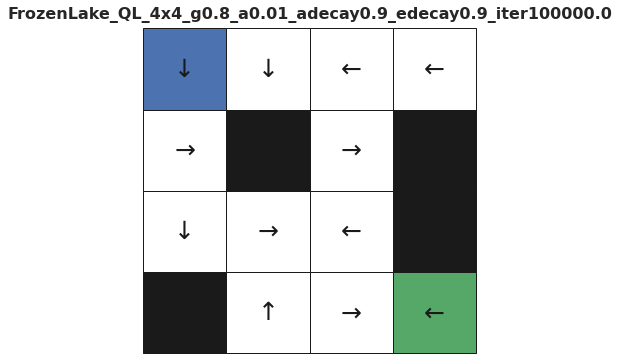

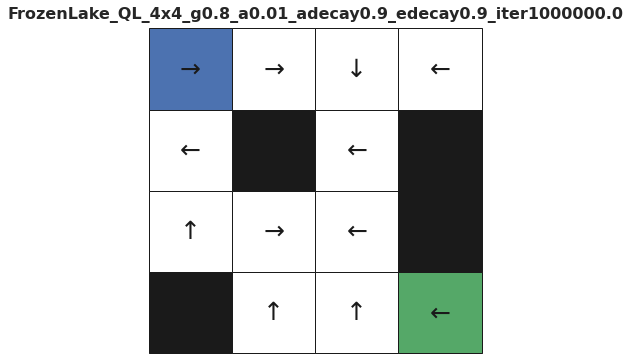

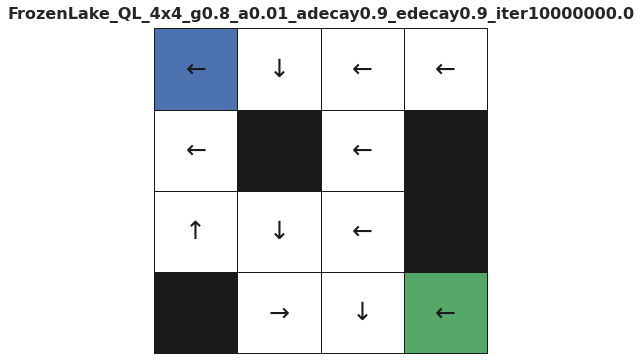

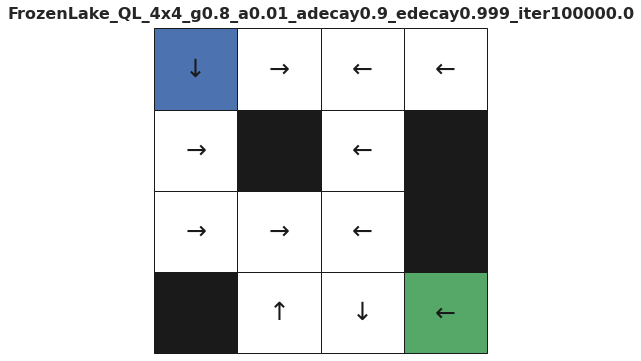

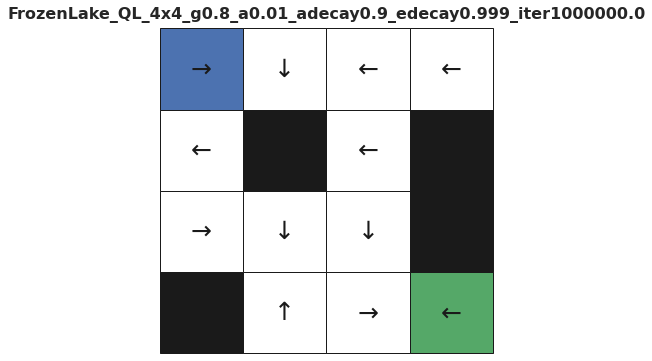

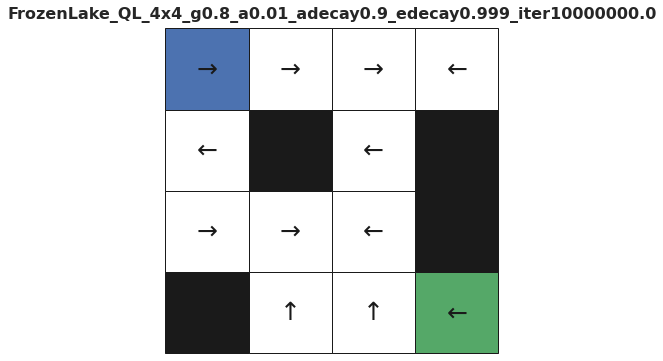

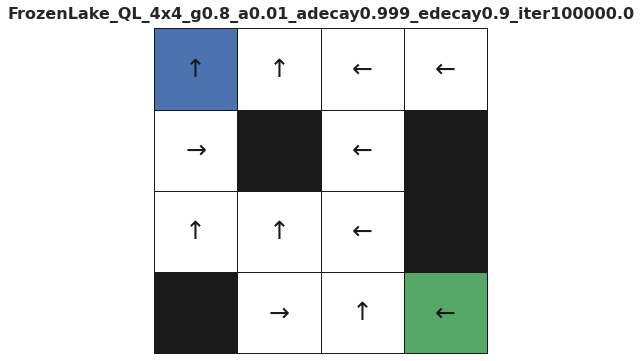

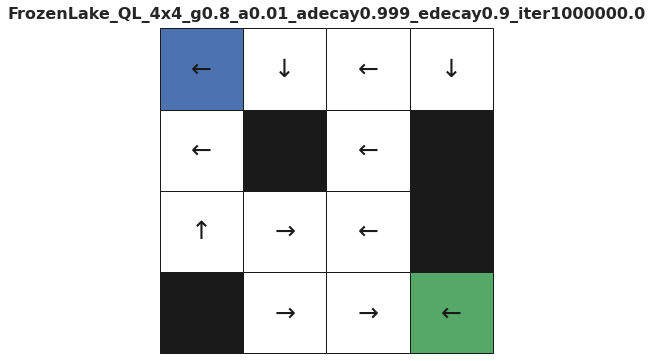

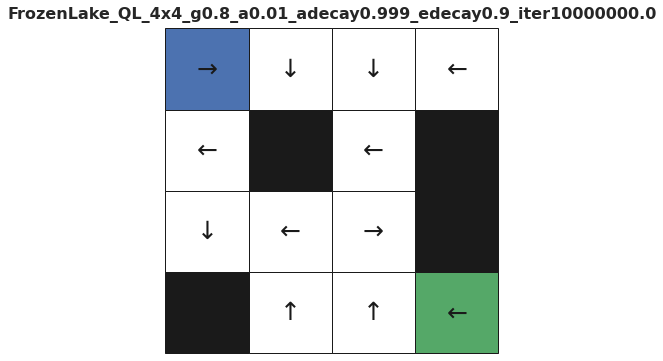

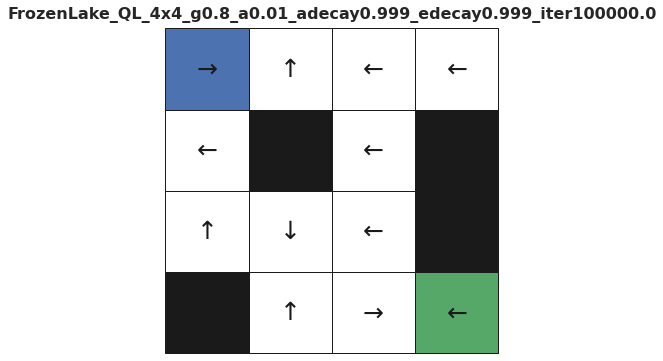

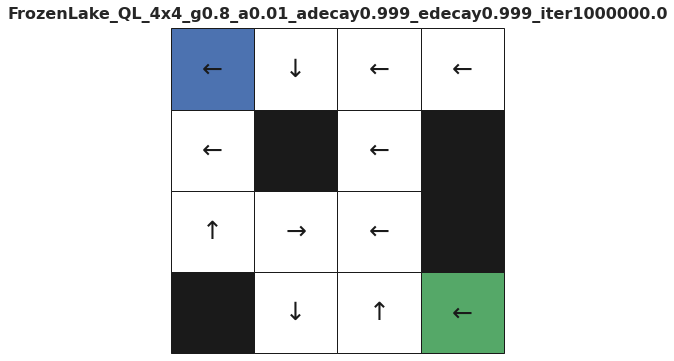

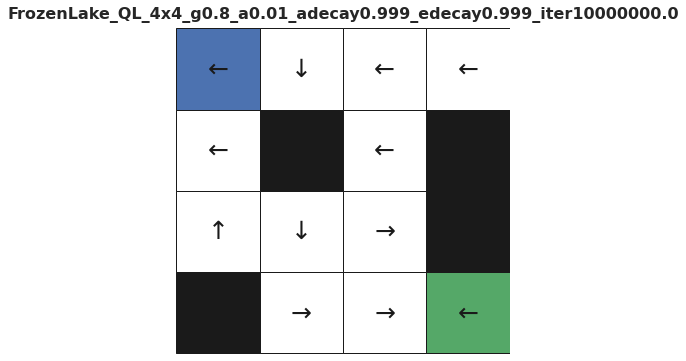

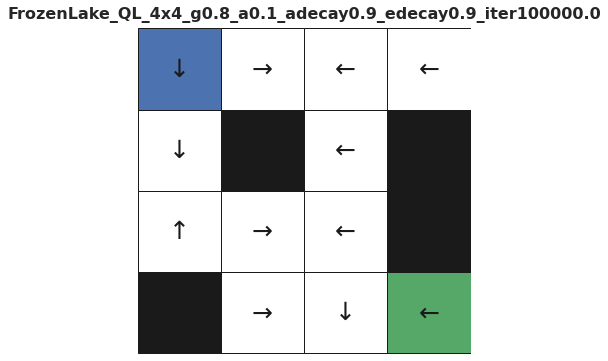

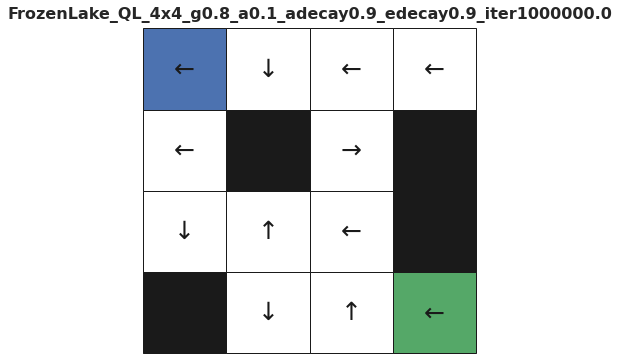

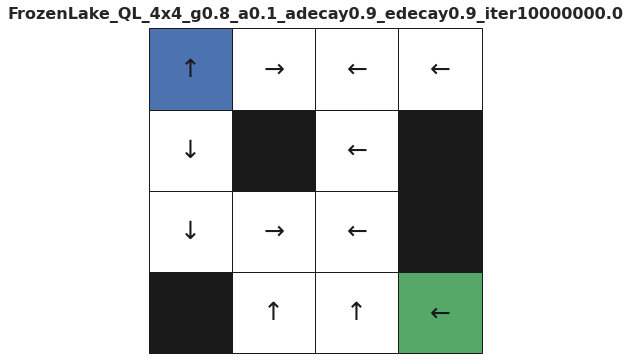

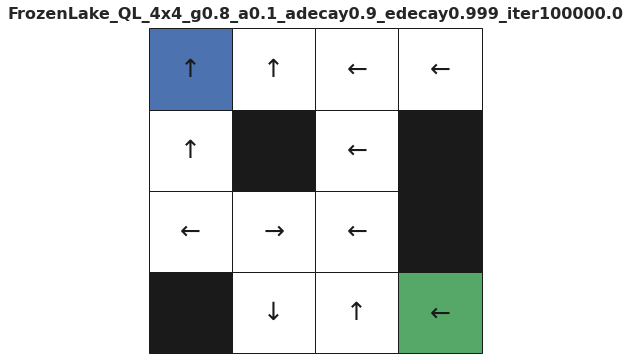

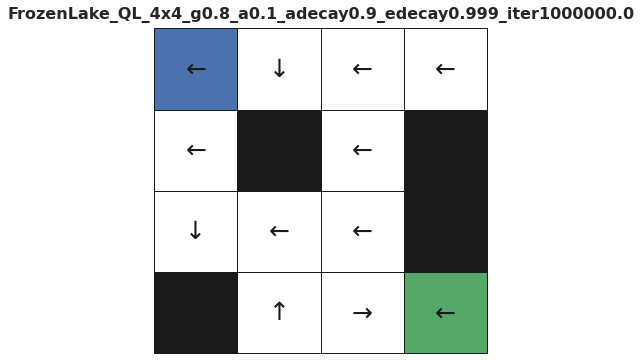

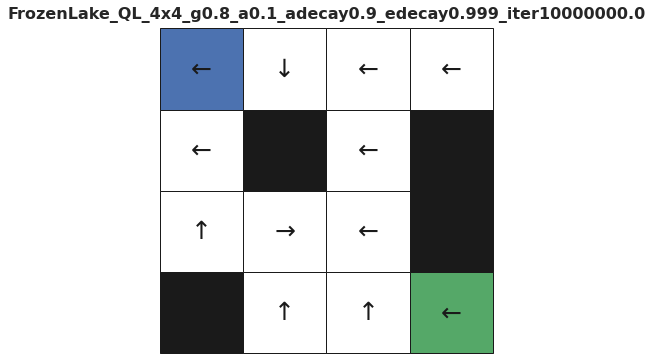

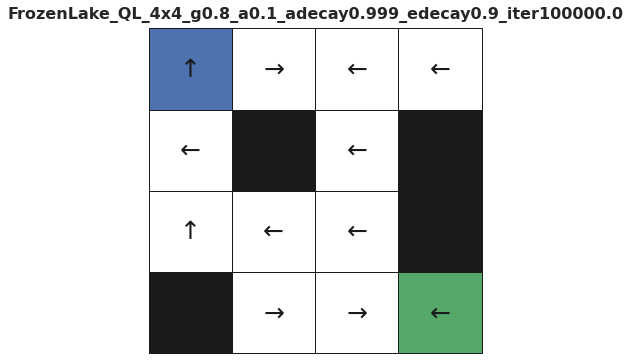

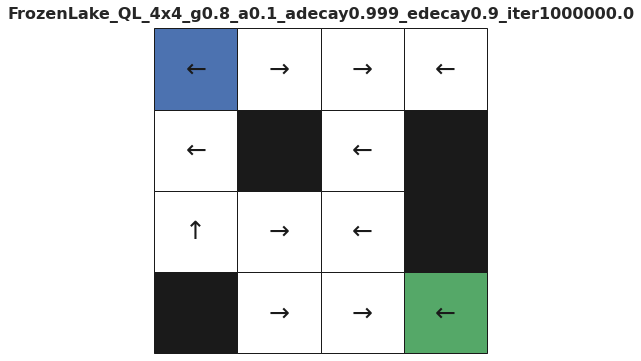

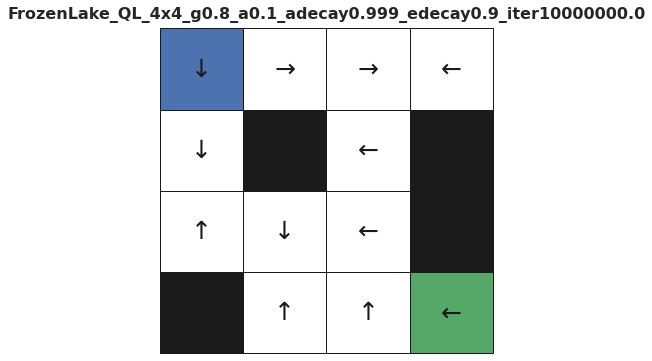

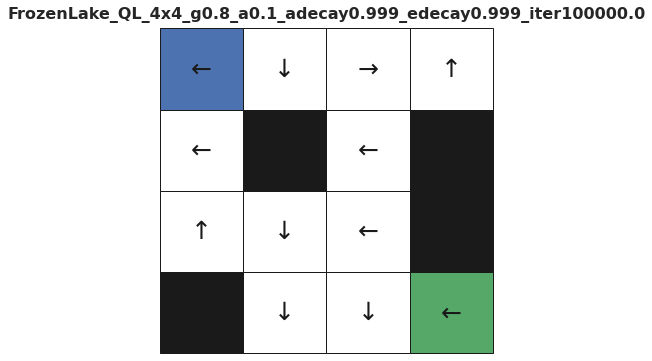

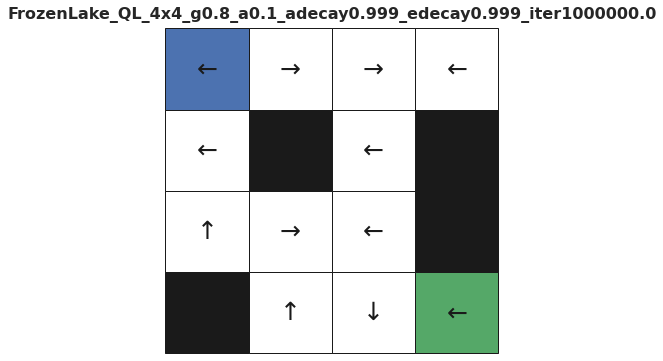

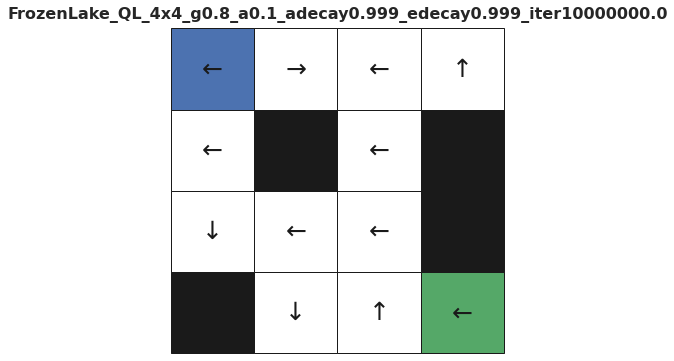

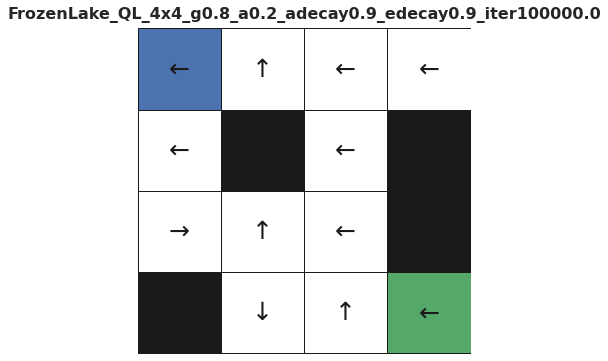

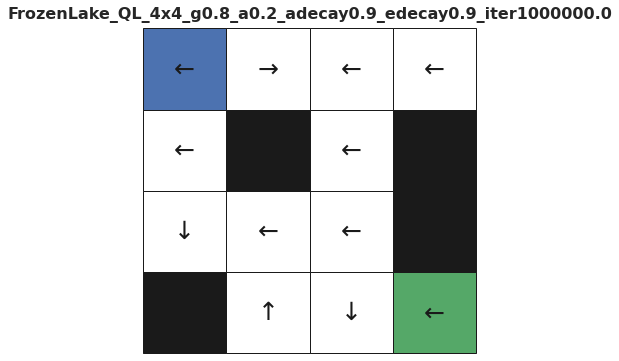

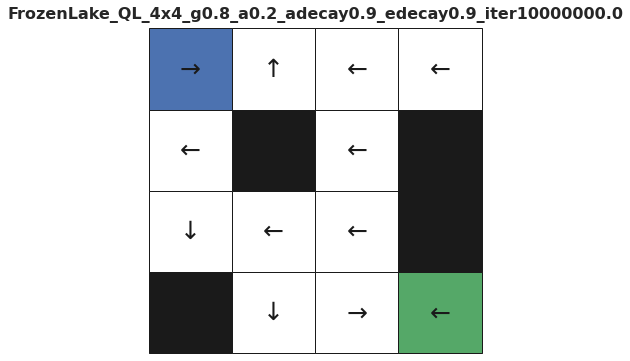

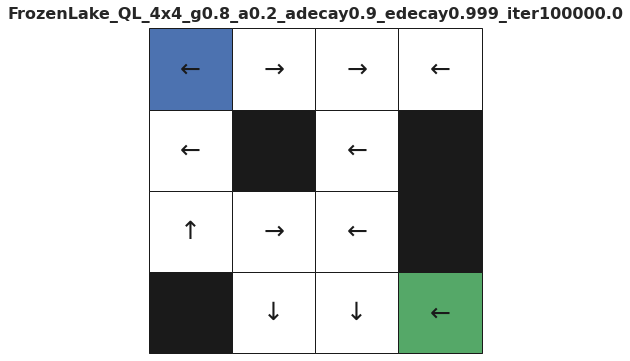

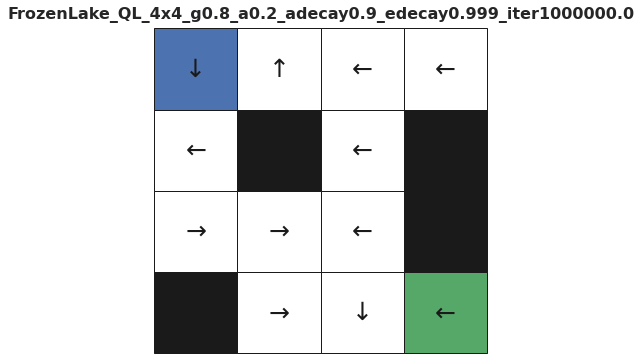

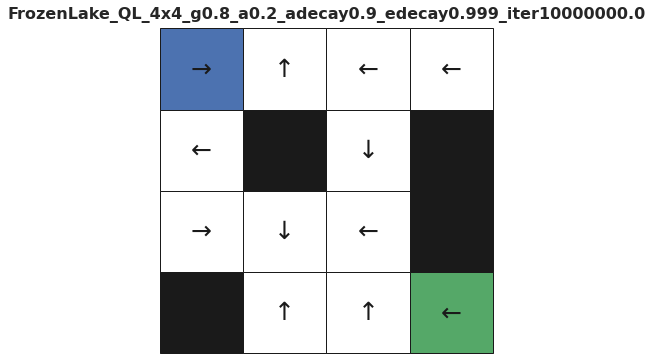

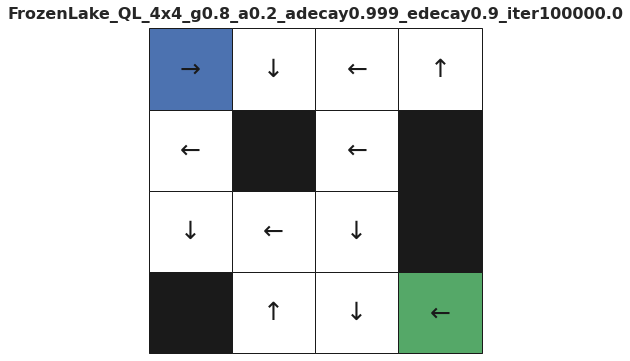

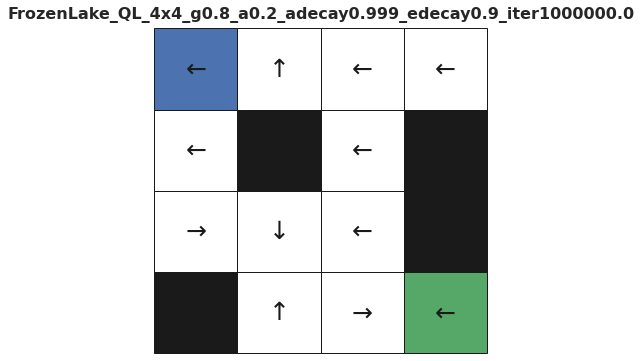

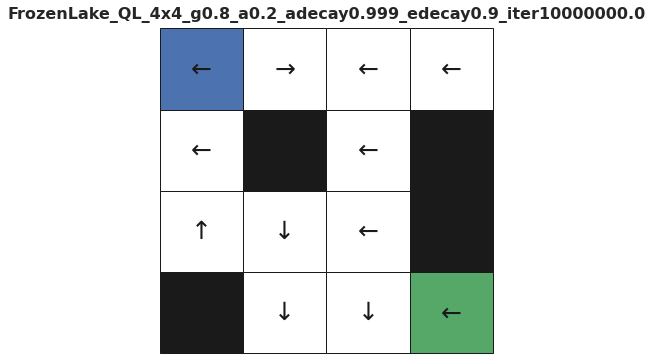

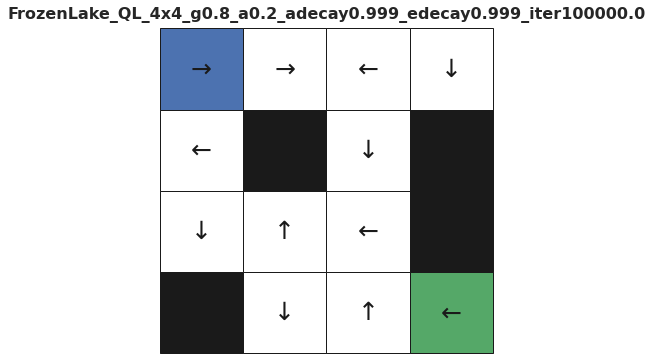

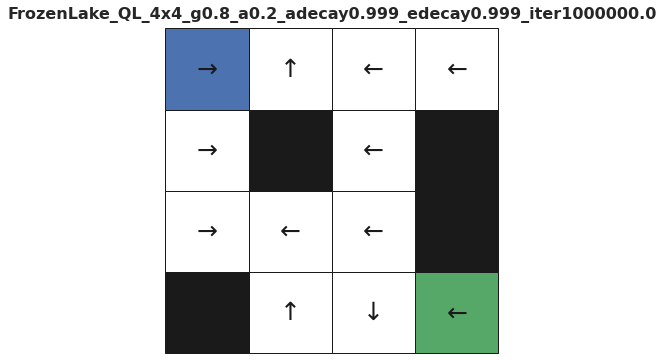

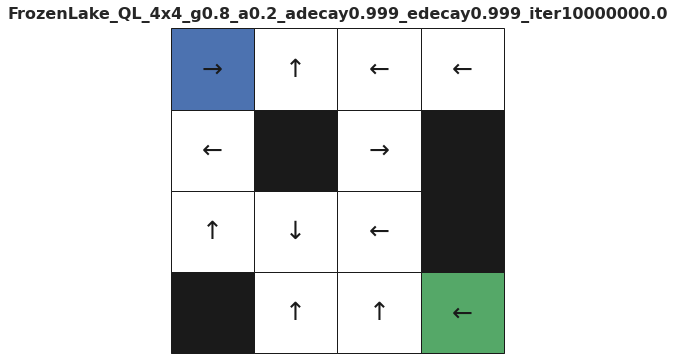

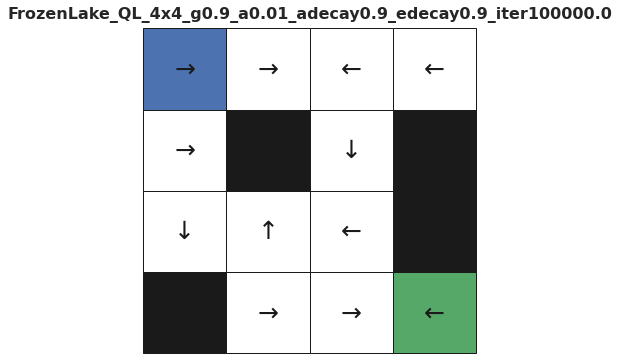

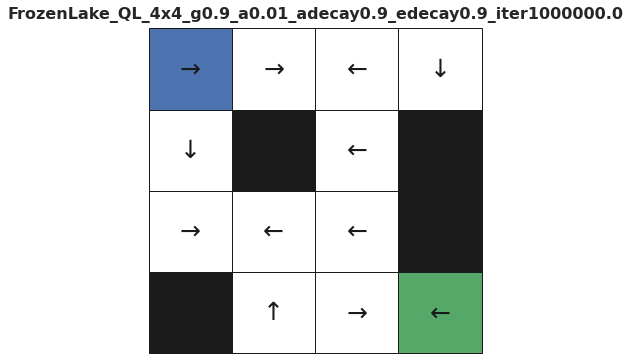

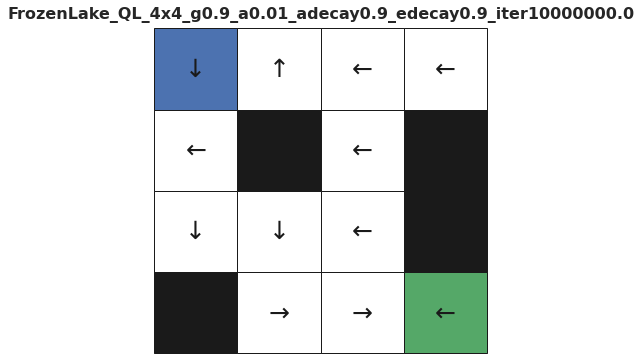

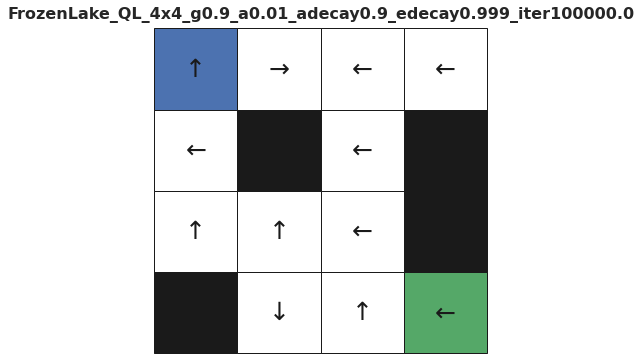

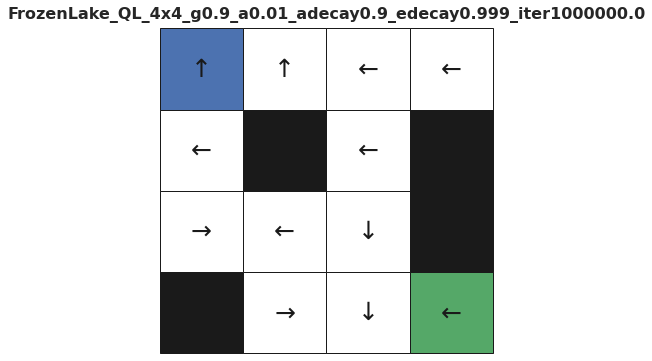

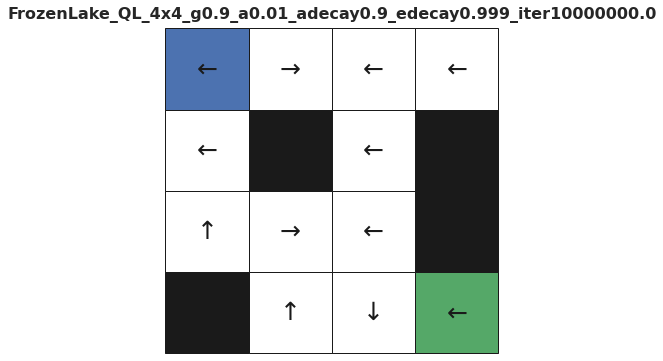

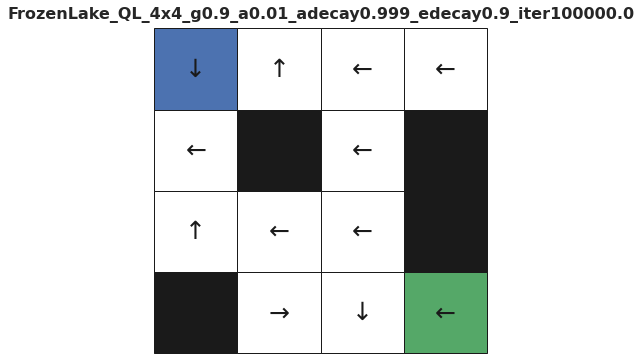

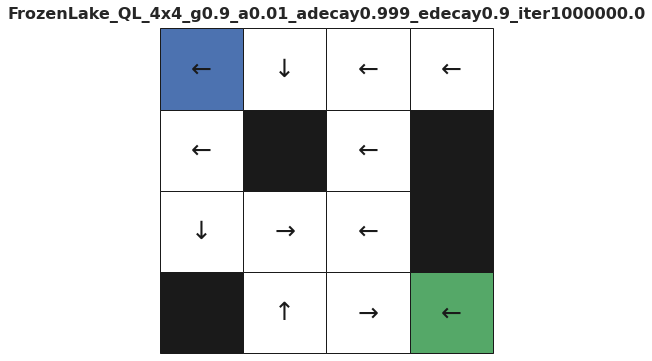

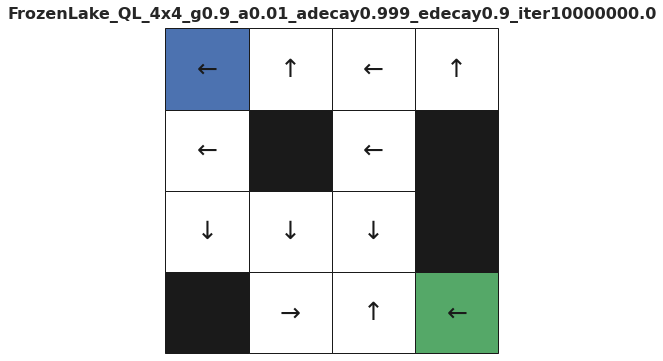

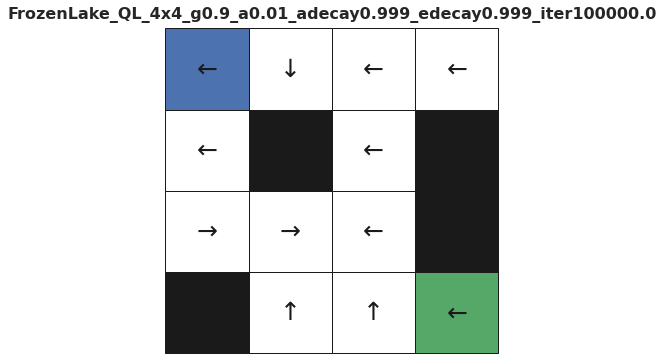

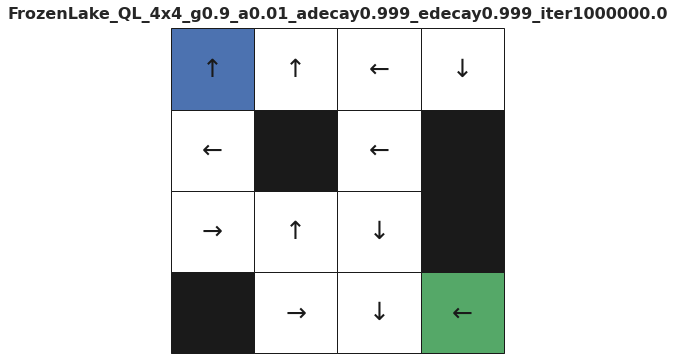

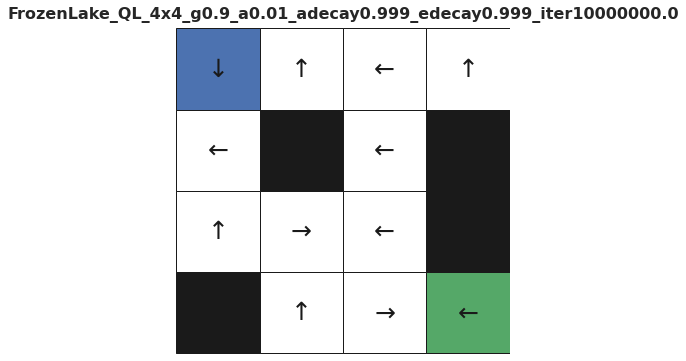

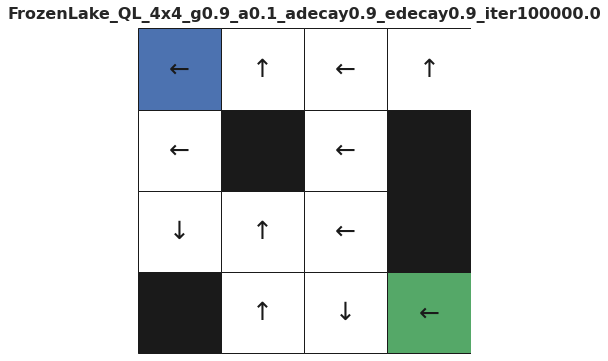

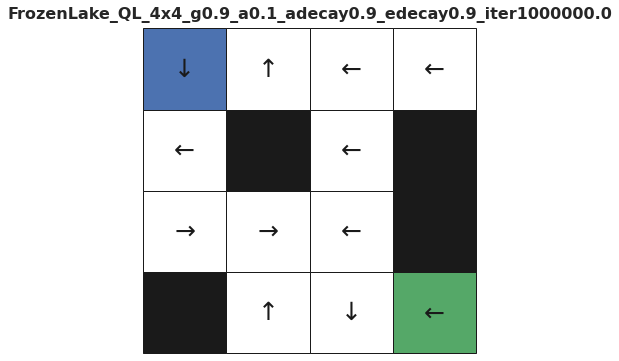

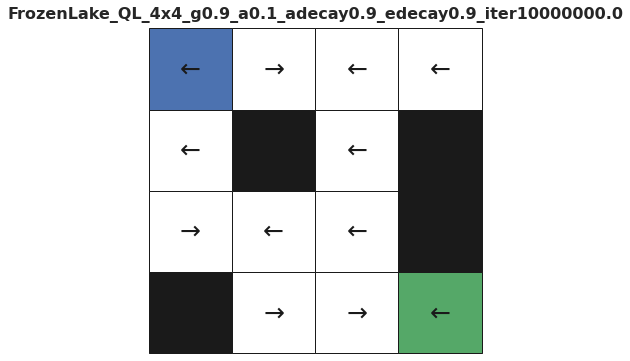

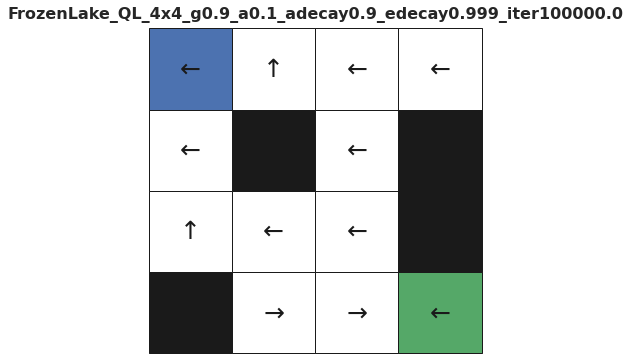

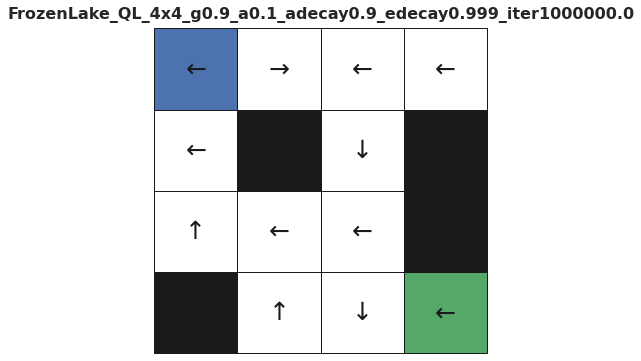

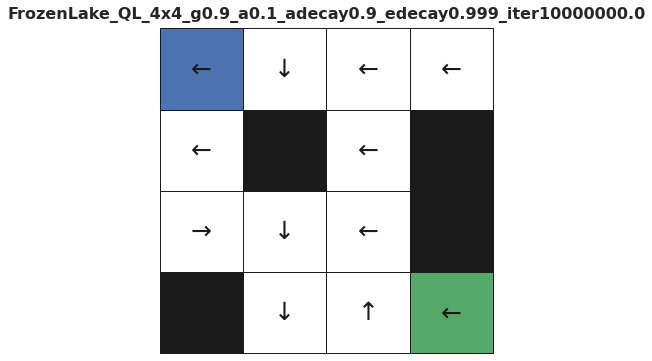

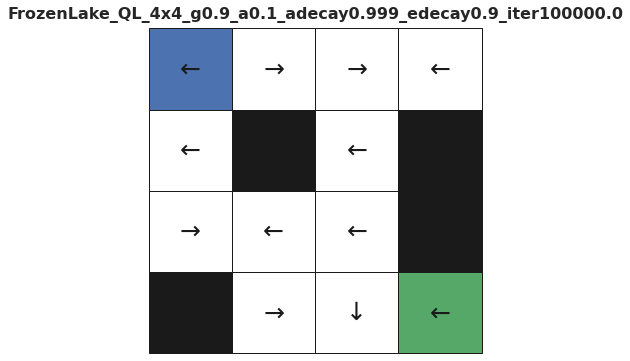

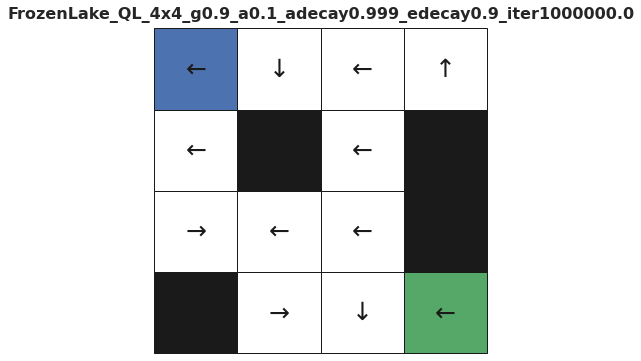

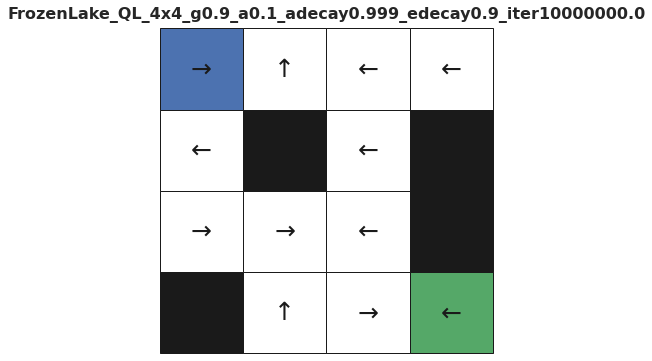

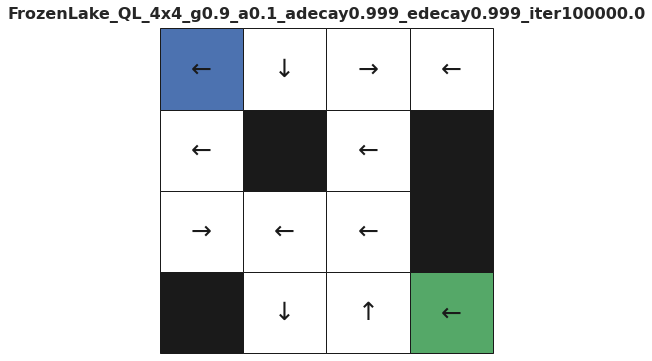

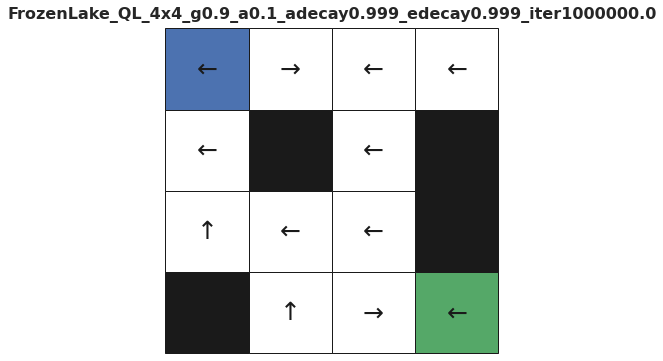

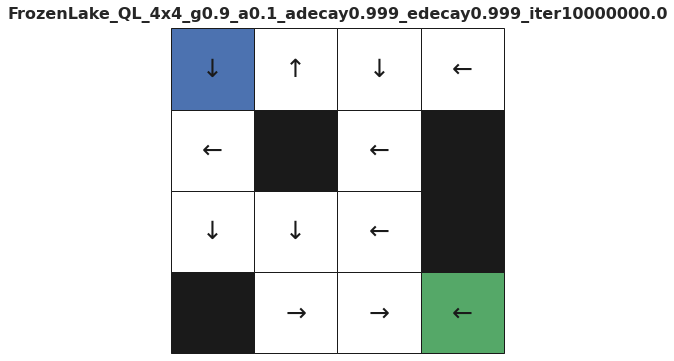

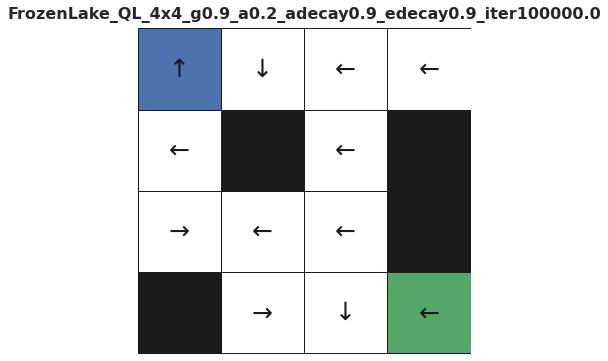

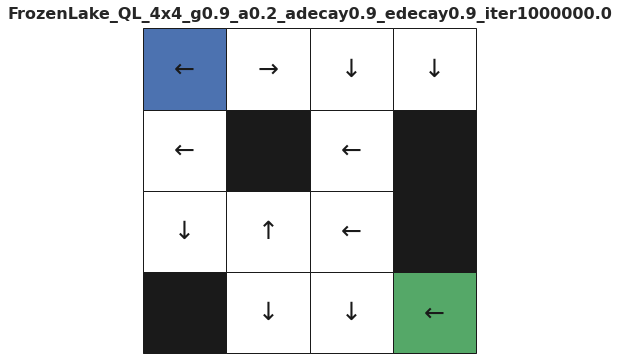

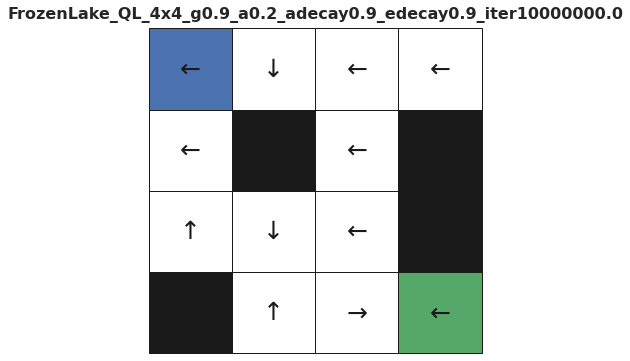

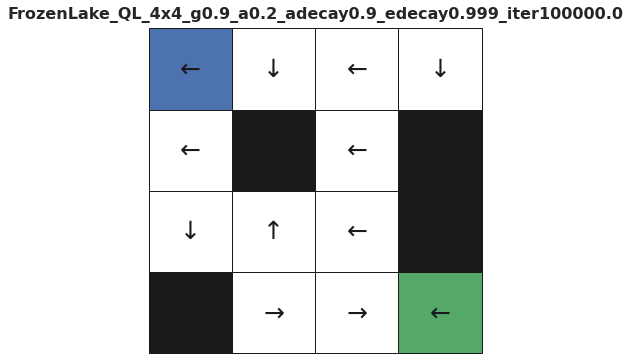

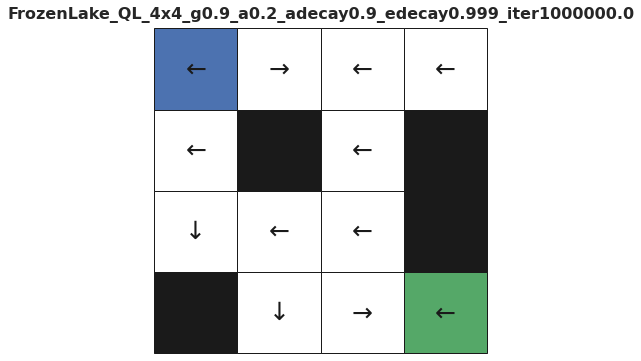

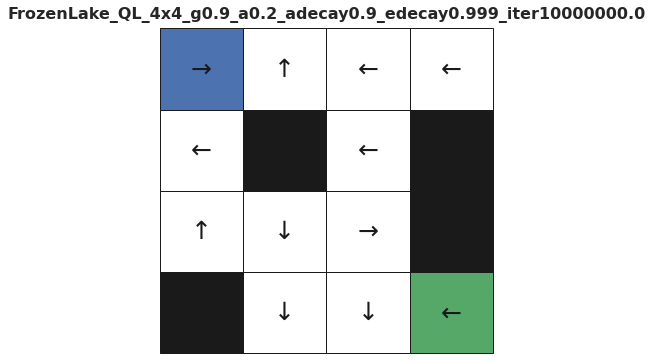

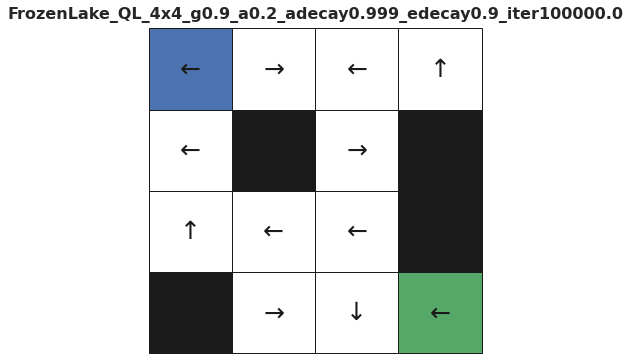

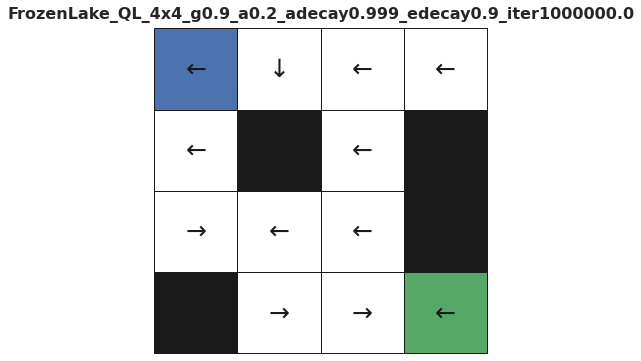

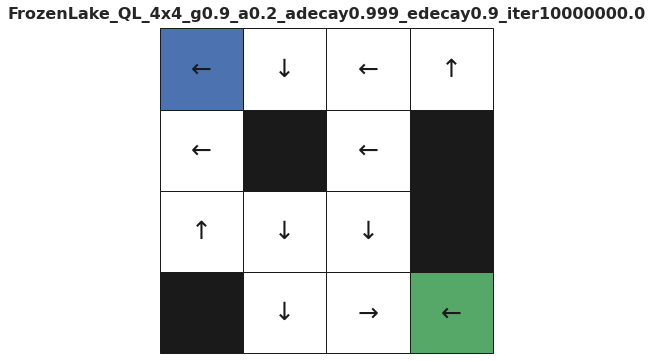

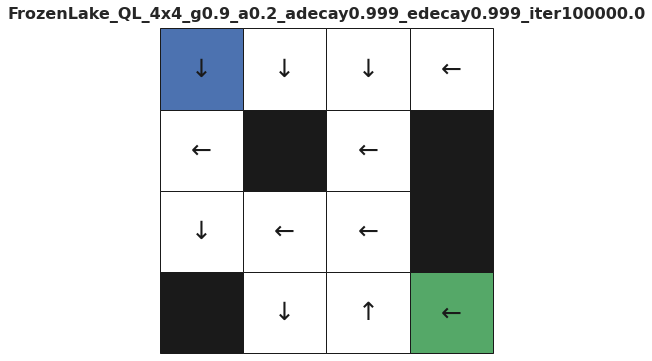

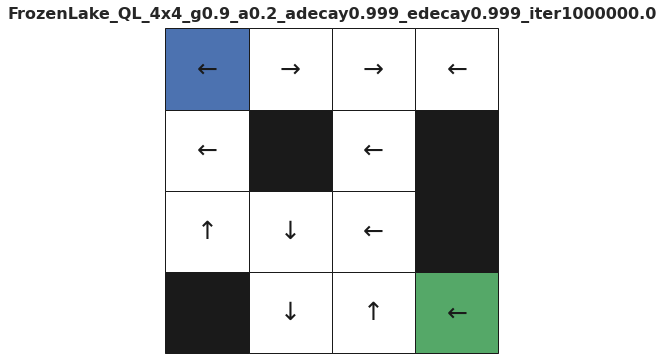

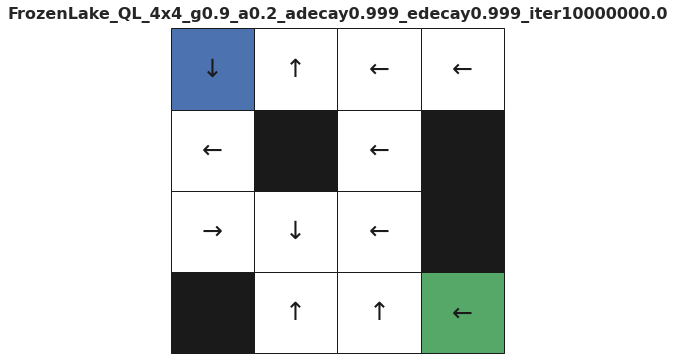

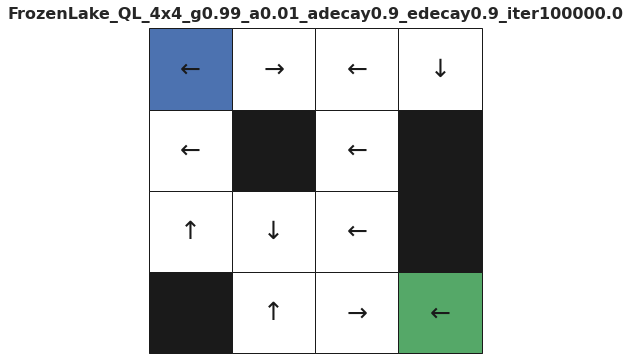

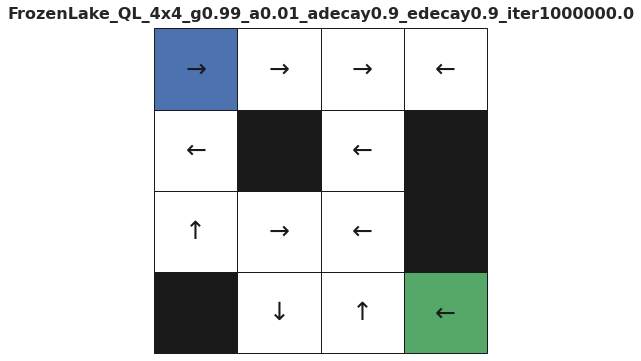

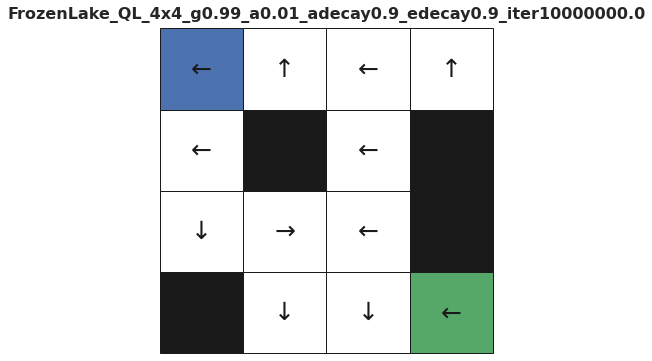

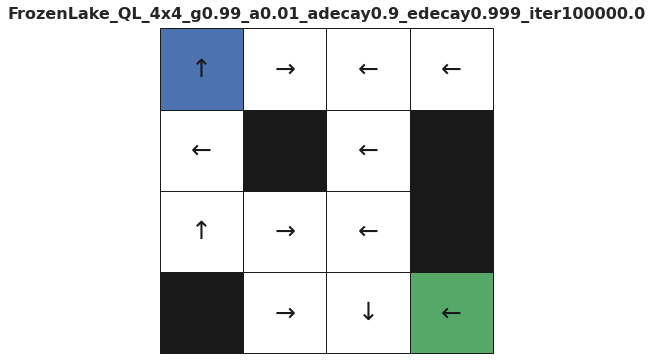

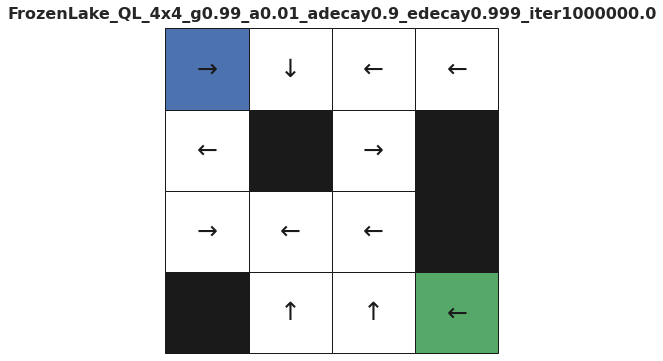

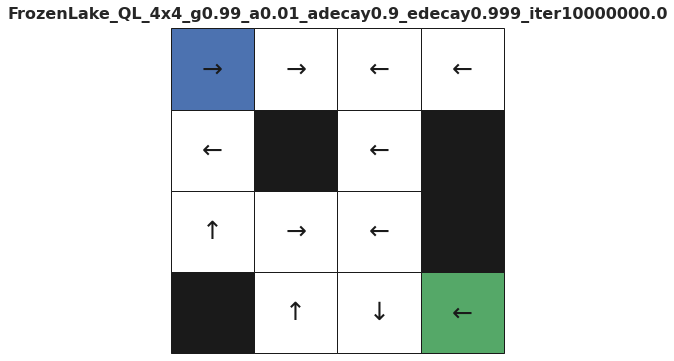

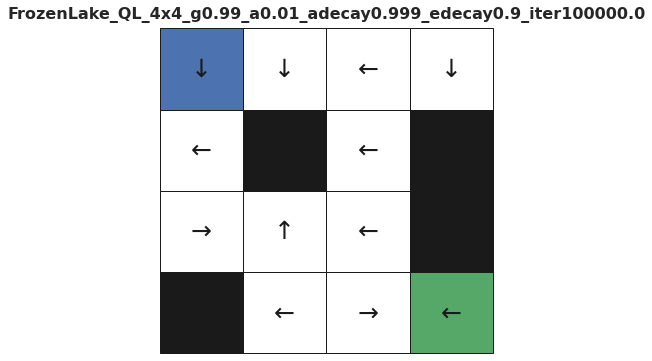

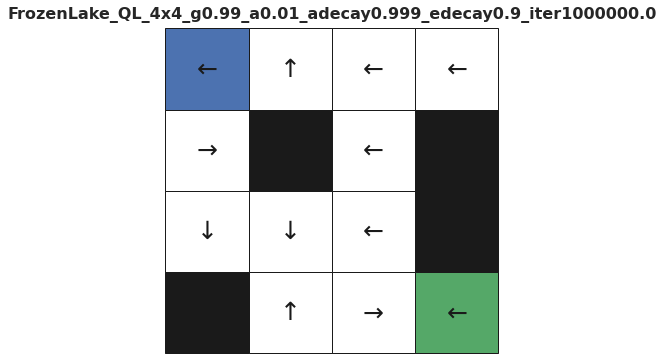

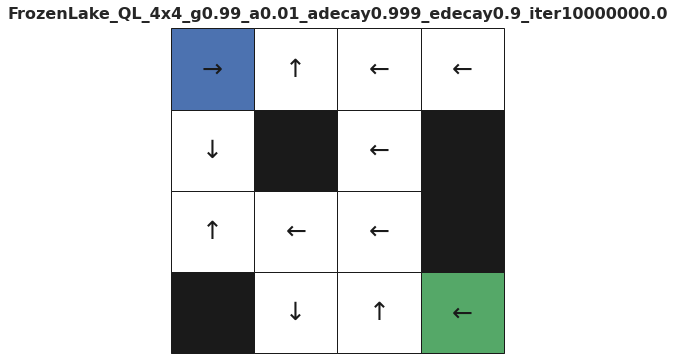

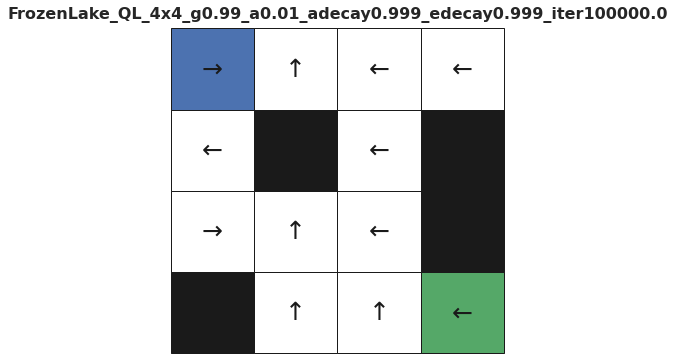

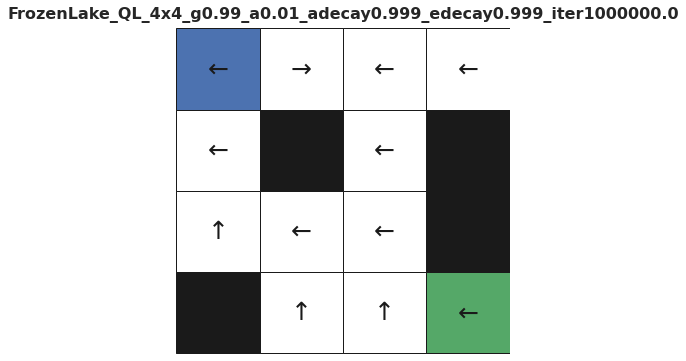

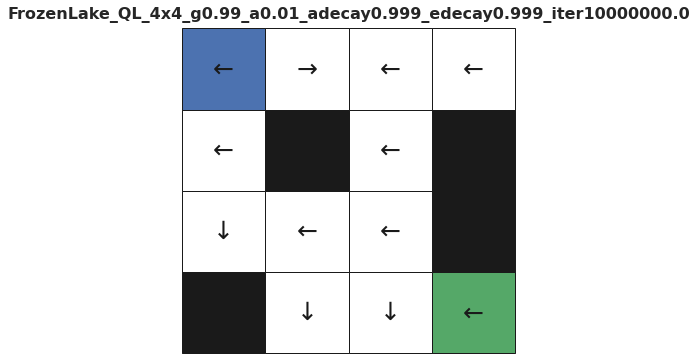

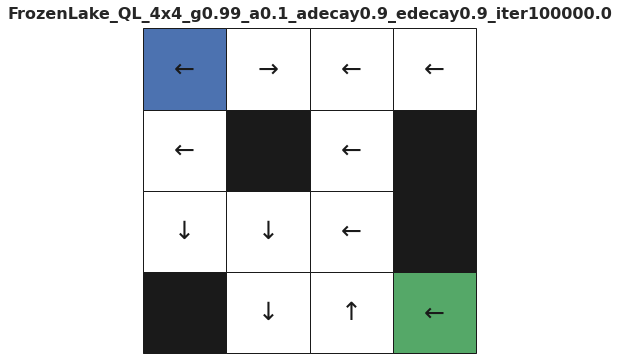

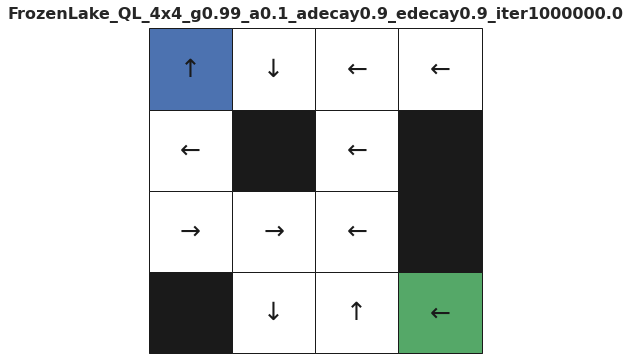

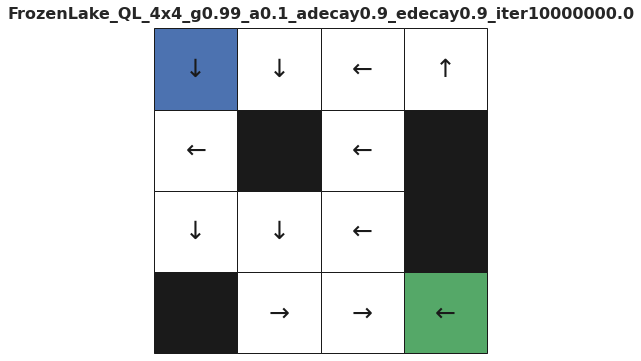

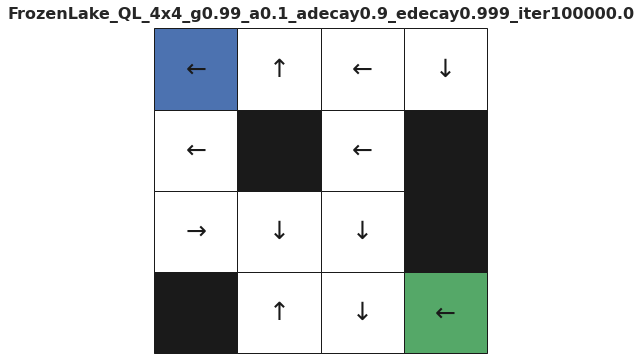

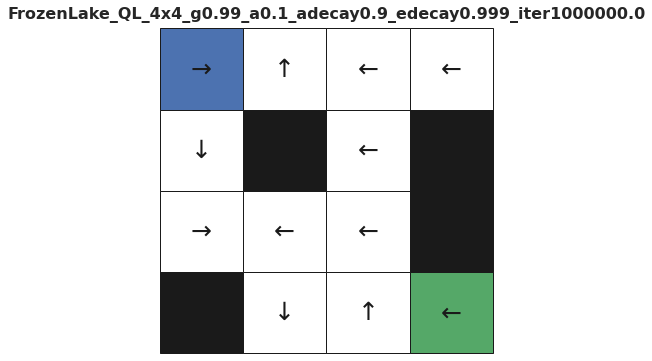

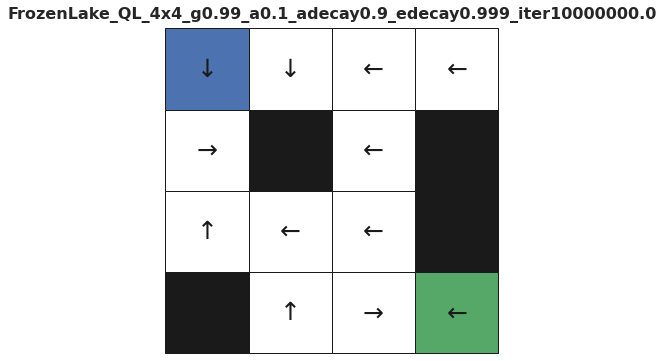

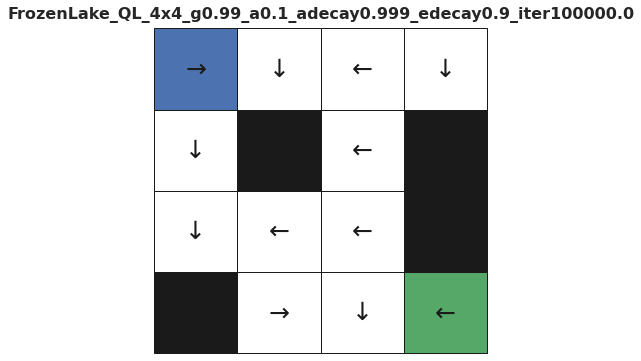

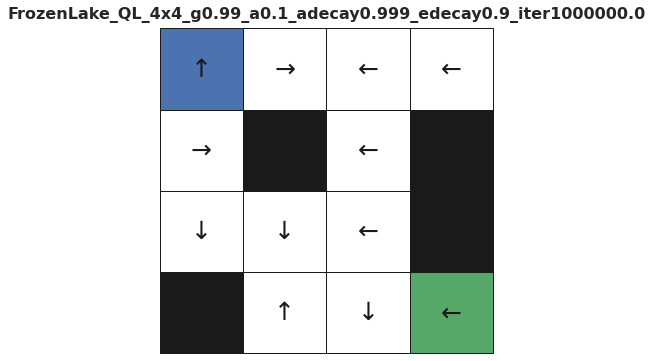

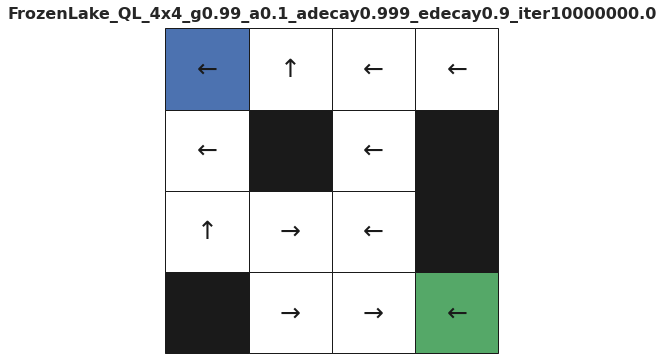

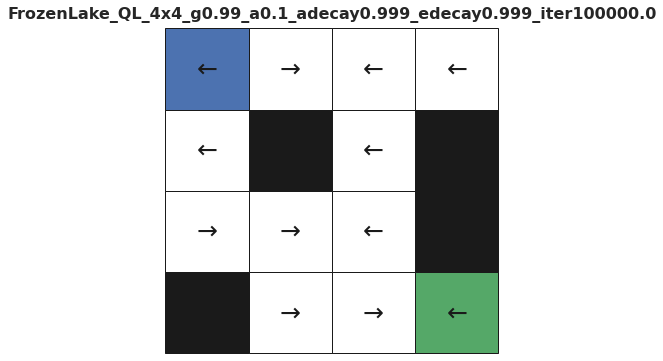

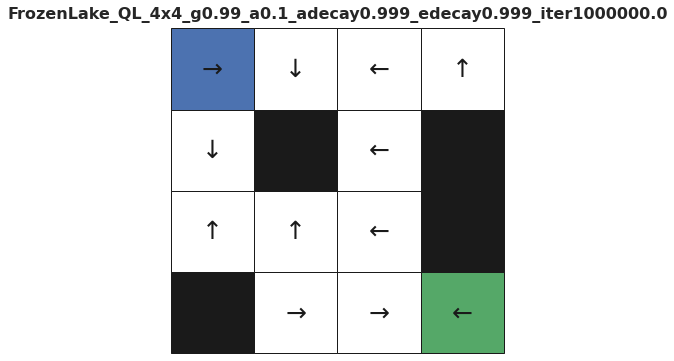

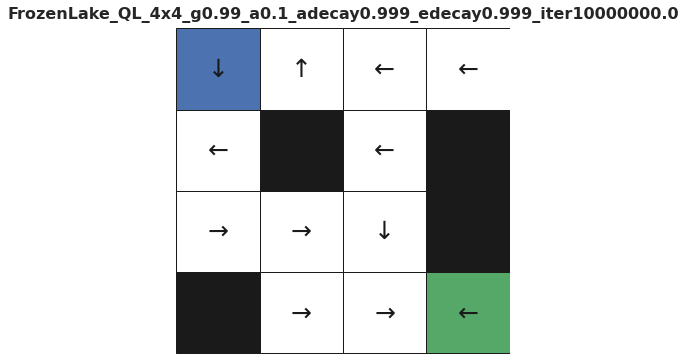

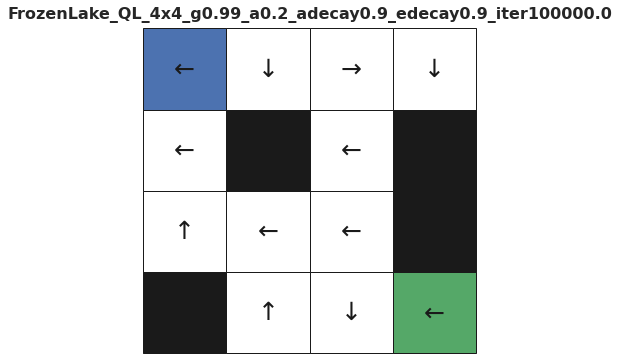

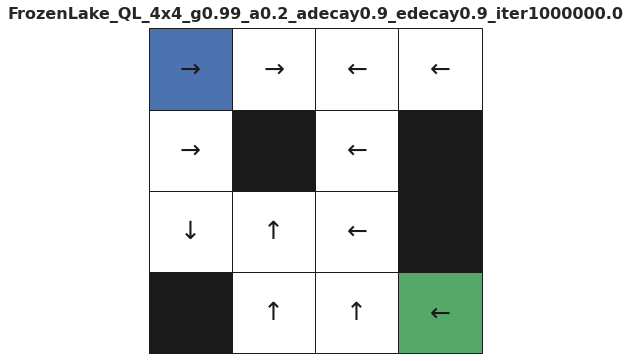

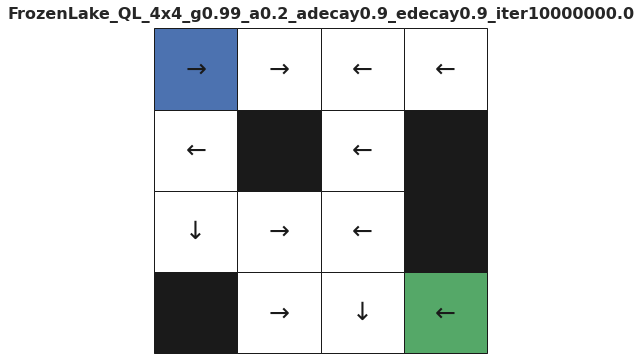

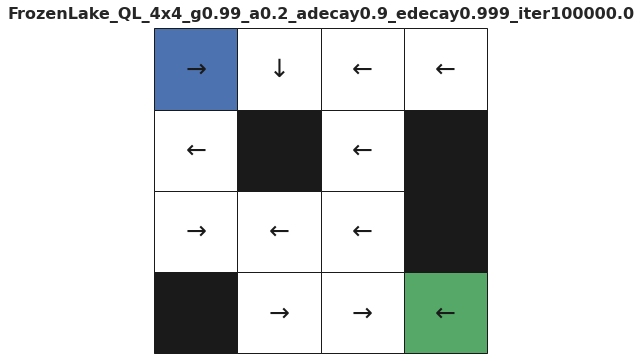

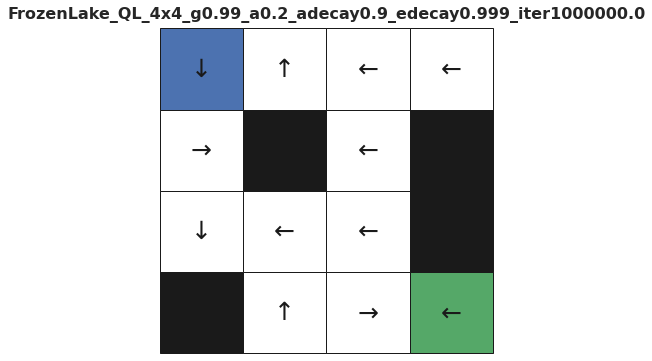

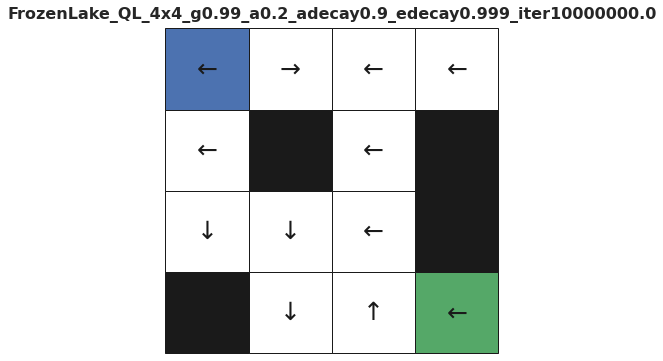

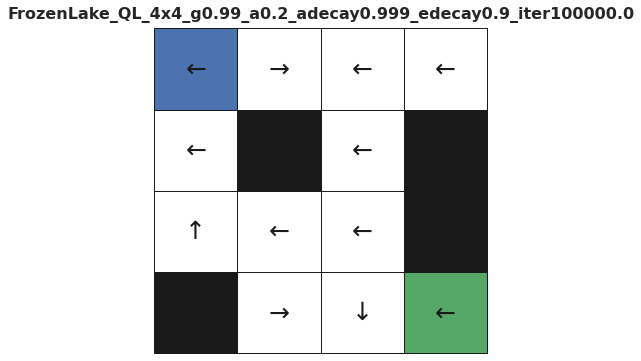

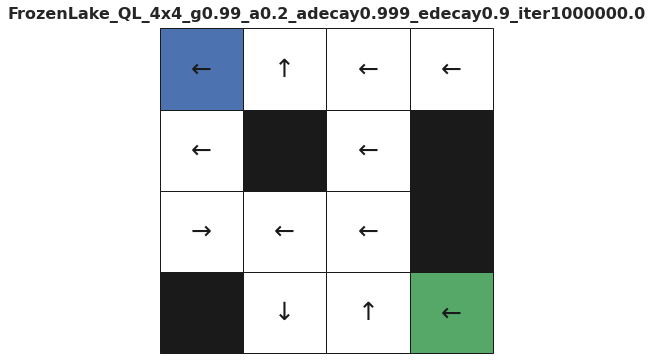

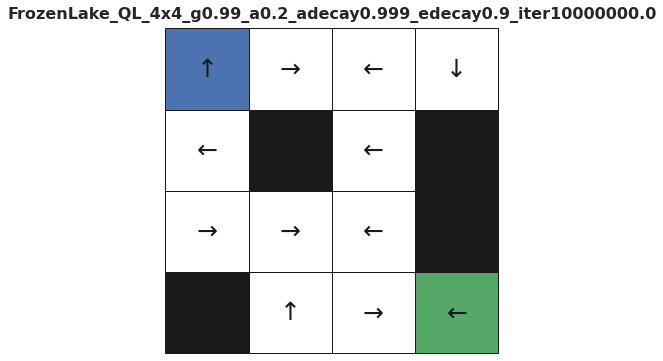

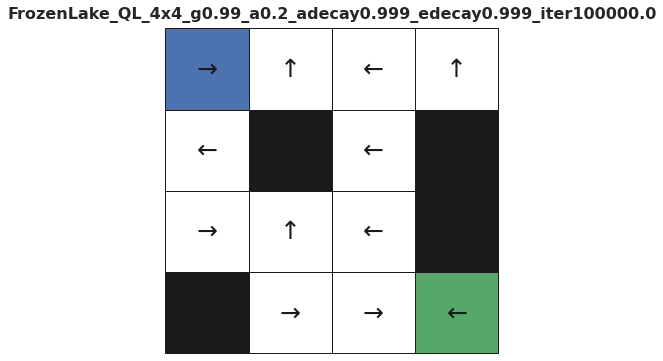

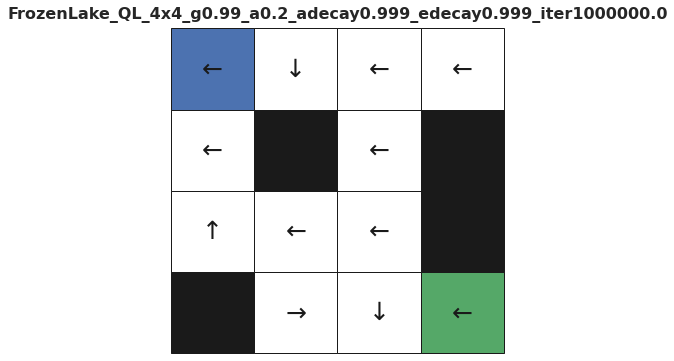

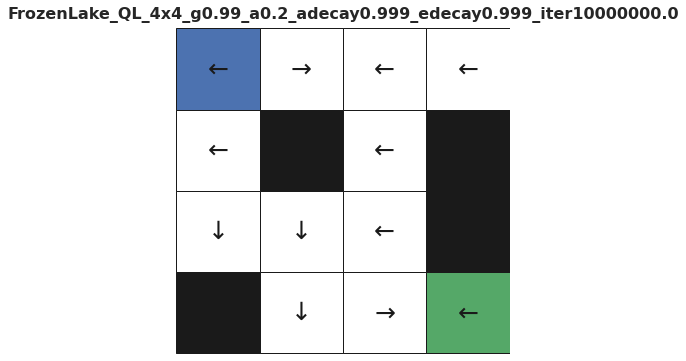

In [ ]:
gammas   = [0.8, 0.9, 0.99]
alphas   = [0.01, 0.1, 0.2]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [1e5, 1e6, 1e7]

''' PROCEED WITH CAUTION >>>> THIS WILL OVERWRITE DATA AND TAKE HOURS

ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=True)

# write all results to csv file
csvFile = 'frozen/QL_results.csv'
ql_data.to_csv(csvFile)

'''

ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=True)

# write all results to csv file
csvFile = 'QL_results.csv'
ql_data.to_csv(csvFile)

#ql_data.head()



In [ ]:
# Read in Q-Learning data
ql_data = pd.read_csv('QL_results.csv')
ql_data.head()

,Unnamed: 0,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0,0.8,0.01,0.9,0.900,100000.0,10.498566,0.086862,12.288889,5.487854,4.5,"{(1, 1, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 3, 2,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,0.8,0.01,0.9,0.900,1000000.0,47.887813,0.325968,12.250000,5.101062,4.8,"{(2, 2, 1, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 3, 3,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,0.8,0.01,0.9,0.900,10000000.0,428.127254,0.541902,41.304291,31.646183,76.9,"{(0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.25e-05,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0....","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.98..."
3,3,0.8,0.01,0.9,0.999,100000.0,4.357133,0.067592,12.675000,5.819740,4.0,"{(1, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 3, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,0.8,0.01,0.9,0.999,1000000.0,43.173828,0.447729,12.434783,5.298286,6.9,"{(2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 3, 2,...","{(0.0, 0.0, 6.25e-05, 6.25e-05, 6.25e-05, 6.25...","{(0.0, 0.0, 0.001, 0.001, 0.001, 0.001, 0.001,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0000000..."


In [ ]:
# Look at correlation matrix
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time', 'success_pct']

# pick out hyperparameters and how succesful they were
df = ql_data[interest]

# See what affected the success_pct the most
ql_corr = df.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


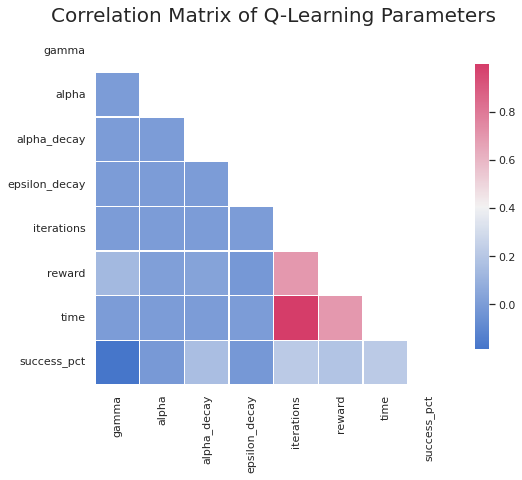

In [ ]:
# Create heatmap of correlation matrix
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,7))
ax.set_title('Correlation Matrix of Q-Learning Parameters', fontsize=20)
mask = np.triu(np.ones_like(ql_corr, dtype=np.bool))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(ql_corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink":.75})

In [ ]:
def plot_QL(dependent, independent, title=None, logscale=False):
    if dependent not in interest:
        print('Dependent variable not available')
        return
    if independent not in interest:
        print('Independent variable not available')
        return
    
    x = np.unique(df[dependent])
    y = []
    
    for i in x:
        y.append(df.loc[df[dependent] == i][independent].mean())
        
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-')
    
    if title == None:
        title = independent + ' vs. ' + dependent
    plt.title(title, fontsize=15)
    plt.xlabel(dependent)
    plt.ylabel(independent)
    plt.grid(True)
    if logscale:
        plt.xscale('log')
    

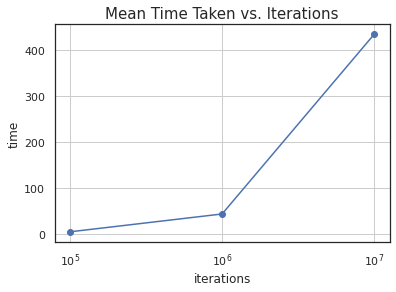

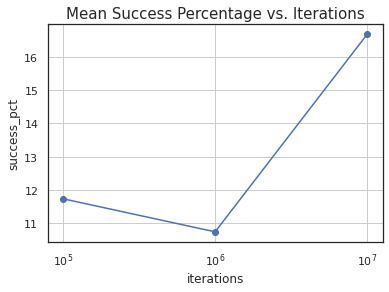

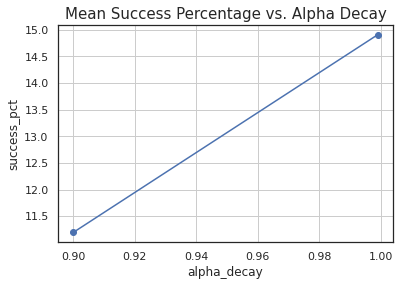

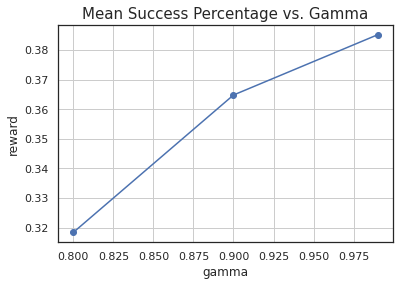

In [ ]:
# Plot values vs. Iterations
plot_QL('iterations', 'time', title='Mean Time Taken vs. Iterations', logscale=True)
plot_QL('iterations', 'success_pct', title='Mean Success Percentage vs. Iterations', logscale=True)

# Plot alpha decay vs success pct
plot_QL('alpha_decay', 'success_pct', title='Mean Success Percentage vs. Alpha Decay')

# Plot results vs. gamma
plot_QL('gamma', 'reward', title='reward vs. Gamma')

Best Result:
	Success = 76.90
	Gamma = 0.80,
	Alpha = 0.01,
	Alpha Decay: 0.900,
	Epsilon Decay: 0.900,
	Iterations: 1.0E+07


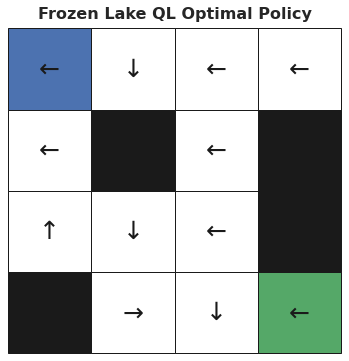

In [ ]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = ql_data['success_pct'].argmax()

best_policy = ql_data['policy'][bestRun]

# reshape the policy since we pulled from a csv file
best_policy = best_policy[1:-1]
best_policy = eval(best_policy)
best_policy = np.array(best_policy)
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake QL Optimal Policy'
plot_lake(env, best_policy, title)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E' 
      % (ql_data['success_pct'].max(), ql_data['gamma'][bestRun], ql_data['alpha'][bestRun], ql_data['alpha_decay'][bestRun], ql_data['epsilon_decay'][bestRun], ql_data['iterations'][bestRun]))